In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%set_env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [25]:
import sys
import cv2
import os
import math
import random
import pickle
import copy
import numpy as np
import pandas as pd
sys.path.append("C:\\Users\\user\\Documents\\Workspace\\MeronymNet-PyTorch\\src")

In [4]:
import torch
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import DataLoader
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

In [144]:
from losses import BoxVAE_losses as loss
from evaluation import metrics
from utils import plot_utils
from utils import data_utils as data_loading
from losses import BoxVAE_losses as loss
from components.AutoEncoder import GCNAutoEncoder
from components.TwoStageAutoEncoder import TwoStageAutoEncoder

In [6]:
import matplotlib.pyplot as plt

In [7]:
batch_size = 128
batch_train_loader, batch_val_loader = data_loading.load_data(obj_data_postfix = '_obj_boundary',
                                                              part_data_post_fix = '_scaled',
                                                              file_postfix = '_combined',
                                                              seed=345,
                                                              batch_size=batch_size)

C:\Users\user\miniconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
import gc
gc.collect()

90

In [186]:
def load_model(model_class, model_settings, model_path, is_base=False):
    
    latent_dims = model_settings['latent_dims']
    batch_size = model_settings['batch_size']
    num_nodes = model_settings['num_nodes']
    bbx_size = model_settings['bbx_size']
    num_classes = model_settings['num_classes']
    label_shape = model_settings['label_shape']
    batch_size = model_settings['batch_size']
    learning_rate = model_settings['learning_rate']
    hidden1 = model_settings['hidden1']
    hidden2 = model_settings['hidden2']
    hidden3 = model_settings['hidden3']
    dense_hidden1=16
    dense_hidden2=32
    adaptive_margin = model_settings['adaptive_margin']
    output_log = False
    area_encoding = False
    variational=False
    if is_base:
        vae = model_class(latent_dims,num_nodes,bbx_size,num_classes,label_shape,hidden1, hidden2, hidden3,
                          dynamic_margin=adaptive_margin,
                         predict_edges=True,
                         predict_class=True,)
        vae.load_state_dict(torch.load(model_path+ '/model_weights.pth'))
        return vae
    
    vae = model_class(latent_dims,
                      num_nodes,
                      bbx_size,
                      num_classes,
                      label_shape,
                      hidden1,
                      hidden2,
                      hidden3,
                      dense_hidden1,
                      dense_hidden2,
                      adaptive_margin,
                      output_log,
                      area_encoding
                    )
    vae.load_state_dict(torch.load(model_path+ '/model_weights.pth'))
    return vae


In [195]:
def generate_objects(batch_loader, model, num_nodes, num_classes, is_base=False):
    
    class_dict = {0:'cow', 1:'sheep', 2:'bird', 3:'person', 4:'cat', 5:'dog', 6:'horse'}
    res_dfs = []
    node_true_arrs = []
    node_pred_arrs = []

    for i, val_data in enumerate(batch_loader, 0):
        val_data.cuda()
        node_data_true = val_data.x
        label_true = node_data_true[:,:1]
        y_true = val_data.y
        class_true = y_true[:, :num_classes]
        X_obj_true = y_true[:, num_classes:]
        adj_true = val_data.edge_index
        class_true  = torch.flatten(class_true)
        batch_size  = len(node_data_true)//num_nodes
        
        if is_base:
            
            obj_true = torch.repeat_interleave(torch.unsqueeze(X_obj_true,-2),num_nodes, -2)
            node_true = node_data_true[:, 1:]
            node_true = torch.reshape(node_true, [batch_size, num_nodes, 4])
            node_data_true[:, 1:] = torch.reshape(metrics.obj_scaling(node_true, obj_true),
                                              (batch_size*num_nodes, 4))
            output = model(adj_true, node_data_true, label_true , class_true, predict_adj_class=True)
            node_data_pred_test = output[0]
            node_true, node_pred, generated_metrics = metrics.get_metrics(node_data_true, None, node_data_pred_test,
                                                                           None,
                                                                           label_true,
                                                                           class_true,
                                                                           num_nodes,
                                                                           num_classes,
                                                                           False,
                                                                           True)
            label_vals = np.reshape(label_true.detach().to("cpu").numpy(), (node_data_pred_test.shape[0],
                                                                            node_data_pred_test.shape[1],1))
        
        else:
            output = model(adj_true, node_data_true, X_obj_true, label_true , class_true, False)
            node_data_pred_test = output[0]
            X_obj_pred_test = output[1]
            node_true, node_pred, generated_metrics = metrics.get_metrics(node_data_true, X_obj_true, node_data_pred_test,
                                                                           X_obj_pred_test,
                                                                           label_true,
                                                                           class_true,
                                                                           num_nodes,
                                                                           num_classes,
                                                                           True, True)
            label_vals = np.reshape(label_true.detach().to("cpu").numpy(), (node_data_pred_test.shape[0],
                                                                            node_data_pred_test.shape[1],1))
        
        
        node_true_arrs.append(node_true)
        node_pred_arrs.append(node_pred*label_vals)
        res_dfs.append(generated_metrics)
        
    node_true_arr = np.concatenate(node_true_arrs)
    
    node_pred_arr = np.concatenate(node_pred_arrs)
    
    result = pd.concat(res_dfs)
    result['obj_class'] = np.where(result['obj_class'].isna(), 0, result['obj_class'])
    result['obj_class'] = result['obj_class'].astype('int')
    result['obj_class'].replace(class_dict, inplace=True)
    result.where(result['part_labels']!=0, np.NaN, inplace=True)
    result['part_labels'] = np.where(result['part_labels'].isna(), 0, result['part_labels'])
    result['part_labels'] = result['part_labels'].astype('int')
    result['id'] = np.repeat(np.array(list(range(int(len(result)/num_nodes)))), 16)
        
    return node_true_arr, node_pred_arr, result
    
    
    

In [193]:
model_paths = [
    'D:/meronym_data/model/adaptive_margin_softmax_margin_loss/GCN-lr-8.5e-05-batch-128-h1-32-h2-16-h3-128-test',
    'D:/meronym_data/model/two_stage_variational_obj_parts_conditioning/Obj-Box-5.5e-05-batch-128-h1-32-h2-16-h3-128-test',
    'D:/meronym_data/model/two_stage_weighted_IOU_no_obj_mse_weighted_obj/Obj-Box-5e-05-batch-128-h1-32-h2-16-h3-128-test',   
    'D:/meronym_data/model/two_stage_gated_adjacency/Obj-Box-5.6e-05-batch-128-h1-32-h2-16-h3-128-test',
]
model_settings =[
     {
        "batch_size": 128,
        "latent_dims": 64,
        "num_nodes": 16,
        "bbx_size": 4,
        "num_classes": 7,
        "label_shape": 1,
        "learning_rate": 0.000085,
        "hidden1": 32,
        "hidden2": 16,
        "hidden3": 128,
        "adaptive_margin":True,
        "is_base": True
    },
    {
        "batch_size": 128,
        "latent_dims": 64,
        "num_nodes": 16,
        "bbx_size": 4,
        "num_classes": 7,
        "label_shape": 1,
        "learning_rate": 0.000055,
        "hidden1": 32,
        "hidden2": 16,
        "hidden3": 128,
        "adaptive_margin":True,
        "is_base": False
    },
    {
        "batch_size": 128,
        "latent_dims": 64,
        "num_nodes": 16,
        "bbx_size": 4,
        "num_classes": 7,
        "label_shape": 1,
        "learning_rate": 0.00005,
        "hidden1": 32,
        "hidden2": 16,
        "hidden3": 128,
        "adaptive_margin":True,
        "is_base": False
    },
    {
        "batch_size": 128,
        "latent_dims": 64,
        "num_nodes": 16,
        "bbx_size": 4,
        "num_classes": 7,
        "label_shape": 1,
        "learning_rate": 0.000056,
        "hidden1": 32,
        "hidden2": 16,
        "hidden3": 128,
        "adaptive_margin":True,
        "is_base": False
    }
]
model_classes = [GCNAutoEncoder, TwoStageAutoEncoder, TwoStageAutoEncoder, TwoStageAutoEncoder]
labels = ['Original', 'Base', 'Margin loss','Two Stage', 'IOU loss fixed', 'Gated Adjacency']
base_model_path ='D:/meronym_data/model/base_model/GCN-lr-8e-05-batch-128-h1-32-h2-16-h3-128-test'
base_model_setting = {
    "latent_dims": 64,
    "batch_size": 128,
    "num_nodes": 16,
    "bbx_size": 4,
    "num_classes": 7,
    "label_shape": 1,
    "learning_rate": 0.00008,
    "hidden1": 32,
    "hidden2": 16,
    "hidden3": 128,
    "adaptive_margin":False,
}
summary_path = 'D:/meronym_data/runs/reconstruction_comparison'

In [196]:
#testing loop
import gc
gc.collect()
num_classes = 7
num_nodes = 16

# base_model = load_model(GCNAutoEncoder, base_model_setting, base_model_path, is_base=True)
# base_node_true, base_node_pred, reconstructions_metrics =  generate_objects(batch_val_loader, base_model,
#                                                                             num_nodes, num_classes, True)

# generated_object_arrs = [base_node_true, base_node_pred]
gen_obj_arrs = [base_node_true, base_node_pred]

for settings, path, model_class in zip(model_settings, model_paths, model_classes):
    print(str(model_class))
    is_base = settings['is_base']
    model = load_model(model_class, settings, path, is_base=is_base)
    node_true, node_pred, reconstructions_metrics =  generate_objects(batch_val_loader, model,
                                                                            num_nodes, num_classes, is_base)
    gen_obj_arrs.append(node_pred)
    


<class 'components.AutoEncoder.GCNAutoEncoder'>
<class 'components.TwoStageAutoEncoder.TwoStageAutoEncoder'>
<class 'components.TwoStageAutoEncoder.TwoStageAutoEncoder'>
<class 'components.TwoStageAutoEncoder.TwoStageAutoEncoder'>


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

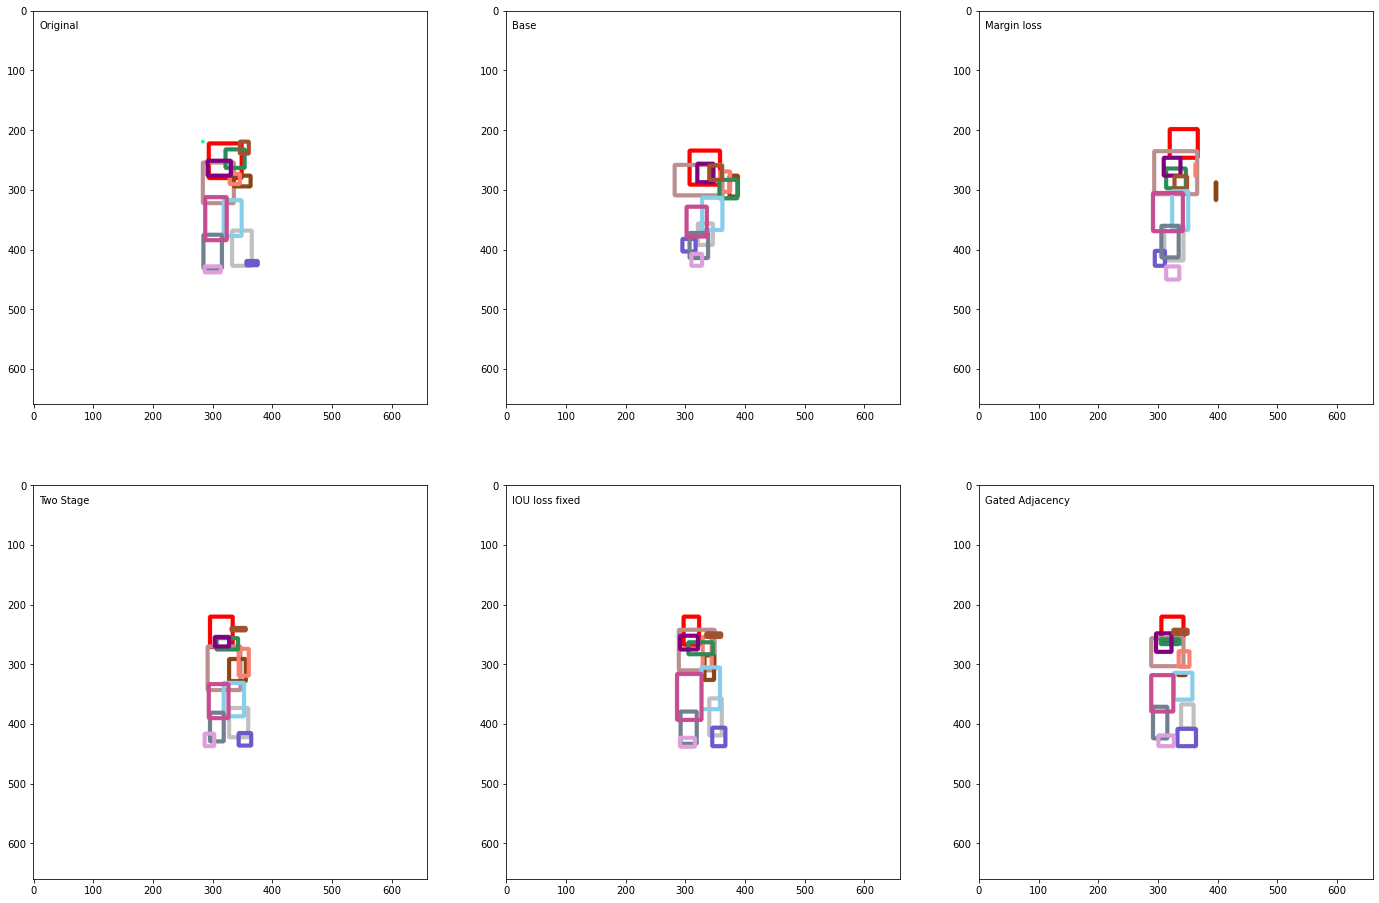

In [216]:

num_objects = len(gen_obj_arrs[0])
num_panels = len(gen_obj_arrs)
class_dict = {0:'cow', 1:'sheep', 2:'bird', 3:'person', 4:'cat', 5:'dog', 6:'horse'}

if not os.path.isdir(summary_path):
    os.mkdir(summary_path)

for obj_class in class_dict.values():
    if not os.path.isdir(summary_path+"/"+obj_class):
        os.mkdir(summary_path+"/"+obj_class)

# for label, obj_arr in zip(labels, gen_obj_arrs):
for i in range(num_objects):
    y = min(3, num_panels)
    x = max(num_panels//3, 1)

    plt.figure()
    f, arr = plt.subplots(x, y)
    f.set_size_inches(24, 16)

    for j in range(num_panels):
        arr[j//3][j%3].imshow(plot_utils.plot_bbx(gen_obj_arrs[j][i]))
        arr[j//3][j%3].text(10, 30, labels[j])

    obj_class = reconstructions_metrics[(reconstructions_metrics['id']==i) 
                    & ~(reconstructions_metrics['obj_class'].isna())]['obj_class'].unique()[0]
    plt.savefig(summary_path+"/"+obj_class+"/"+str(i)+'-comp.png')
    plt.close('all')
    
